In [1]:
%matplotlib inline

In [2]:
from pathlib import Path

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import TensorDataset, DataLoader
from torch.optim.lr_scheduler import _LRScheduler
import os

In [4]:
seed = 1
np.random.seed(seed)
torch.cuda.set_device(0)  # if you have more than one CUDA device

In [5]:
ROOT = '../../datasets/csv/dummy'
SAMPLE = os.path.join(ROOT, 'sample_submission.csv')
TRAIN = os.path.join(ROOT, 'X_train.csv')
TARGET = os.path.join(ROOT, 'y_train.csv')
TEST = os.path.join(ROOT, 'X_test.csv')

ID_COLS = ['series_id', 'measurement_number']

x_cols = {
    'series_id': np.uint32,
    'measurement_number': np.uint32,
    'orientation_X': np.float32,
    'orientation_Y': np.float32,
    'orientation_Z': np.float32,
    'orientation_W': np.float32,
    'angular_velocity_X': np.float32,
    'angular_velocity_Y': np.float32,
    'angular_velocity_Z': np.float32,
    'linear_acceleration_X': np.float32,
    'linear_acceleration_Y': np.float32,
    'linear_acceleration_Z': np.float32
}

y_cols = {
    'series_id': np.uint32,
    'group_id': np.uint32,
    'surface': str
}

In [6]:
x_trn = pd.read_csv(TRAIN, usecols=x_cols.keys(), dtype=x_cols)
x_tst = pd.read_csv(TEST, usecols=x_cols.keys(), dtype=x_cols)
y_trn = pd.read_csv(TARGET, usecols=y_cols.keys(), dtype=y_cols)

In [7]:
def create_datasets(X, y, test_size=0.2, dropcols=ID_COLS, time_dim_first=False):
    enc = LabelEncoder()
    y_enc = enc.fit_transform(y)
    X_grouped = create_grouped_array(X)
    if time_dim_first:
        X_grouped = X_grouped.transpose(0, 2, 1)
    X_train, X_valid, y_train, y_valid = train_test_split(X_grouped, y_enc, test_size=0.1)
    X_train, X_valid = [torch.tensor(arr, dtype=torch.float32) for arr in (X_train, X_valid)]
    y_train, y_valid = [torch.tensor(arr, dtype=torch.long) for arr in (y_train, y_valid)]
    train_ds = TensorDataset(X_train, y_train)
    valid_ds = TensorDataset(X_valid, y_valid)
    return train_ds, valid_ds, enc


def create_grouped_array(data, group_col='series_id', drop_cols=ID_COLS):
    X_grouped = np.row_stack([
        group.drop(columns=drop_cols).values[None]
        for _, group in data.groupby(group_col)])
    return X_grouped


def create_test_dataset(X, drop_cols=ID_COLS):
    X_grouped = np.row_stack([
        group.drop(columns=drop_cols).values[None]
        for _, group in X.groupby('series_id')])
    X_grouped = torch.tensor(X_grouped.transpose(0, 2, 1)).float()
    y_fake = torch.tensor([0] * len(X_grouped)).long()
    return TensorDataset(X_grouped, y_fake)


def create_loaders(train_ds, valid_ds, bs=512, jobs=0):
    train_dl = DataLoader(train_ds, bs, shuffle=True, num_workers=jobs)
    valid_dl = DataLoader(valid_ds, bs, shuffle=False, num_workers=jobs)
    return train_dl, valid_dl


def accuracy(output, target):
    return (output.argmax(dim=1) == target).float().mean().item()

In [8]:
class CyclicLR(_LRScheduler):
    
    def __init__(self, optimizer, schedule, last_epoch=-1):
        assert callable(schedule)
        self.schedule = schedule
        super().__init__(optimizer, last_epoch)

    def get_lr(self):
        return [self.schedule(self.last_epoch, lr) for lr in self.base_lrs]

In [9]:
def cosine(t_max, eta_min=0):
    
    def scheduler(epoch, base_lr):
        t = epoch % t_max
        return eta_min + (base_lr - eta_min)*(1 + np.cos(np.pi*t/t_max))/2
    
    return scheduler

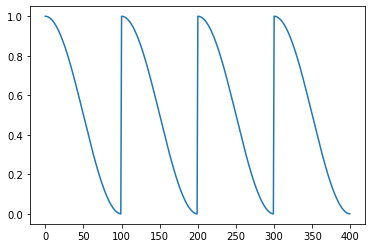

In [10]:
n = 100
sched = cosine(n)
lrs = [sched(t, 1) for t in range(n * 4)]
plt.plot(lrs)

In [34]:


class LSTMClassifier(nn.Module):
    """Very simple implementation of LSTM-based time-series classifier."""
    
    def __init__(self, input_dim, hidden_dim, layer_dim, output_dim):
        super().__init__()
        self.hidden_dim = hidden_dim
        self.layer_dim = layer_dim
        self.rnn = nn.LSTM(input_dim, hidden_dim, layer_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)
        self.batch_size = None
        self.hidden = None
    
    def forward(self, x):
        h0, c0 = self.init_hidden(x)
        out, (hn, cn) = self.rnn(x, (h0, c0)) # (h0, c0)
        out = F.dropout(out, 0.3) # chris
        #out = self.fc(hn[-1])
        out = self.fc(out[:, -1, :]) # out at the last time step
        return out
    
    def init_hidden(self, x):
        h0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim)
        c0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim)
        return [t.cuda() for t in (h0, c0)]



In [35]:
print('Preparing datasets')
trn_ds, val_ds, enc = create_datasets(x_trn, y_trn['surface'])


Preparing datasets


In [36]:
bs = 128
print(f'Creating data loaders with batch size: {bs}')
trn_dl, val_dl = create_loaders(trn_ds, val_ds, bs)

Creating data loaders with batch size: 128


In [37]:
input_dim = 10    
hidden_dim = 256
layer_dim = 3
output_dim = 9
seq_dim = 128

# Dummy EEG data (batch_size=100, seq_length=50, input_dim=10)
# X = torch.randn(100, 50, 10)  # (100 samples, 50 time steps, 10 features per time step)

lr = 0.0005
n_epochs = 50
iterations_per_epoch = len(trn_dl)
best_acc = 0
patience, trials = 100, 0

model = LSTMClassifier(input_dim, hidden_dim, layer_dim, output_dim)
model = model.cuda()
criterion = nn.CrossEntropyLoss()
opt = torch.optim.RMSprop(model.parameters(), lr=lr)
sched = CyclicLR(opt, cosine(t_max=iterations_per_epoch * 2, eta_min=lr/100))

print('Start model training')

for epoch in range(1, n_epochs + 1):
    
    for i, (x_batch, y_batch) in enumerate(trn_dl):
        model.train()
        x_batch = x_batch.cuda()
        y_batch = y_batch.cuda()
        sched.step()
        opt.zero_grad()
        out = model(x_batch)
        loss = criterion(out, y_batch)
        loss.backward()
        opt.step()
    
    model.eval()
    correct, total = 0, 0
    for x_val, y_val in val_dl:
        x_val, y_val = [t.cuda() for t in (x_val, y_val)]
        out = model(x_val)
        preds = F.log_softmax(out, dim=1).argmax(dim=1)
        total += y_val.size(0)
        correct += (preds == y_val).sum().item()
    
    acc = correct / total

    if epoch % 5 == 0:
        print(f'Epoch: {epoch:3d}. Loss: {loss.item():.4f}. Acc.: {acc:2.2%}')

    if acc > best_acc:
        trials = 0
        best_acc = acc
        torch.save(model.state_dict(), 'best.pth')
        print(f'Epoch {epoch} best model saved with accuracy: {best_acc:2.2%}')
    else:
        trials += 1
        if trials >= patience:
            print(f'Early stopping on epoch {epoch}')
            break

Start model training


C:\Users\Prinzessin\anaconda3\envs\feta\lib\site-packages\torch\optim\lr_scheduler.py:138: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


Epoch 1 best model saved with accuracy: 23.62%
Epoch 4 best model saved with accuracy: 24.93%
Epoch:   5. Loss: 1.7855. Acc.: 27.56%
Epoch 5 best model saved with accuracy: 27.56%
Epoch 6 best model saved with accuracy: 27.82%
Epoch 8 best model saved with accuracy: 31.50%
Epoch 9 best model saved with accuracy: 35.70%
Epoch:  10. Loss: 1.6401. Acc.: 34.91%
Epoch 11 best model saved with accuracy: 38.58%
Epoch:  15. Loss: 1.6205. Acc.: 43.04%
Epoch 15 best model saved with accuracy: 43.04%
Epoch 18 best model saved with accuracy: 43.31%
Epoch:  20. Loss: 1.4384. Acc.: 43.04%
Epoch 21 best model saved with accuracy: 46.98%
Epoch:  25. Loss: 1.3412. Acc.: 49.34%
Epoch 25 best model saved with accuracy: 49.34%
Epoch 28 best model saved with accuracy: 50.13%
Epoch 29 best model saved with accuracy: 54.33%
Epoch:  30. Loss: 1.3115. Acc.: 52.76%
Epoch 33 best model saved with accuracy: 54.86%
Epoch:  35. Loss: 1.1846. Acc.: 55.12%
Epoch 35 best model saved with accuracy: 55.12%
Epoch 39 best

In [20]:
print('The training is finished! Restoring the best model weights')

The training is finished! Restoring the best model weights


In [21]:
model.load_state_dict(torch.load('best.pth'))

<All keys matched successfully>

In [22]:
model.eval()

LSTMClassifier(
  (rnn): LSTM(10, 256, num_layers=3, batch_first=True)
  (fc): Linear(in_features=256, out_features=9, bias=True)
)

In [23]:
test_dl = DataLoader(create_test_dataset(x_tst), batch_size=128, shuffle=False)

In [24]:
test = []
print('Predicting on test dataset')
for batch, _ in test_dl:
    batch = batch.permute(0, 2, 1)
    out = model(batch.cuda())
    print(out.shape)
    y_hat = F.log_softmax(out, dim=1).argmax(dim=1)
    test += y_hat.tolist()

Predicting on test dataset
torch.Size([128, 9])
torch.Size([128, 9])
torch.Size([128, 9])
torch.Size([128, 9])
torch.Size([128, 9])
torch.Size([128, 9])
torch.Size([128, 9])
torch.Size([128, 9])
torch.Size([128, 9])
torch.Size([128, 9])
torch.Size([128, 9])
torch.Size([128, 9])
torch.Size([128, 9])
torch.Size([128, 9])
torch.Size([128, 9])
torch.Size([128, 9])
torch.Size([128, 9])
torch.Size([128, 9])
torch.Size([128, 9])
torch.Size([128, 9])
torch.Size([128, 9])
torch.Size([128, 9])
torch.Size([128, 9])
torch.Size([128, 9])
torch.Size([128, 9])
torch.Size([128, 9])
torch.Size([128, 9])
torch.Size([128, 9])
torch.Size([128, 9])
torch.Size([104, 9])


In [25]:
submit = pd.read_csv(SAMPLE)
submit['surface'] = enc.inverse_transform(test)
submit.to_csv('submit.csv', index=None)